<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/MARCA-Color.jpg" title="Title text" width="50%" height="50%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales II-2018 </h1>

<H3 align='center'> Tarea 3 - Redes Recurrentes y Autoencoders </H3>
<hr style="height:2px;border:none"/>



**Temas**  
* Diseño e implementación de Redes Neuronales Recurrentes (RNN).
* Regularización en Redes Recurrentes.
* Autoencoders tradicionales y sus aplicaciones

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 21 de Diciembre (sin posibilidad de extensiones)
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<margarita.bugueno.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<cvalle@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF395-II-2018] 

<hr style="height:2px;border:none"/>

La tarea se divide en dos secciones:

[1.](#primero) RNN sobre texto    
[2.](#segundo) Autoencoder en MNIST  


### **Nota Importante:**  
Para esta actividad **si es que no se cuenta con GPU** se recomienda utilizar el entorno virtual de __[Colaboratory - Google](https://colab.research.google.com/)__* . Así, podrá programar en la nube con recursos elevados y luego descargar el Jupyter Notebook y entregarlo en modo Informe. 


<a id="primero"></a>
## 1. RNN sobre texto

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (*Groningen Meaning Bank*), para reconocimiento de entidades y tagger. En específico, trabajaremos con el dataset proprocionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas del tipo *many to many* y *many to one*.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />


Descargue los datos de la página de Kaggle y cárguelos mediante *pandas*.
```python
import numpy as np
import pandas as pd
df_ner = pd.read_csv("./entity-annotated-corpus/ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)
```


> a) En esta primera instancia trabajaremos con la tarea de realizar un NER *tag* (**Named Entity Recognition**) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia, sin *shift*, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset **¿Por qué es conveniente utilizar *lemma* en vez de la palabra misma *word*?**
```python
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]
```
Luego de esto cree una estructura que contendrá todas las sentencias u oraciones y otra estructura que contendrá los las etiquetas (*tags*), esto es un arreglo de arreglos de *lemmas* y un arreglo de arreglos de *tags* respectivamente. **¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?**
```python
dataX,dataY = [],[]
lemmas,labels = set(), set()  #uniques
for fila in dataset.values:
    if fila[-1]=="__START1__": 
        dataX.append(np.asarray(sentence))
        dataY.append(np.asarray(labels_sentence))
        sentence= []
        label_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila[0])#add lemma
    labels_sentence.append(fila[3]) #TAG
dataX = np.asarray(dataX[1:]) #data to  array
dataY = np.asarray(dataY[1:])
```    

> b) Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?**[[1]](#refs) Realice un gráfico de la cantidad de datos por clase. Comente.

> c) Es necesario transformar los textos para que puedan ser entregados apropiadamente a la red, por lo que será necesario crear una función que codifique cada posible *lemma* a un número y cada posible *tag* a otro número, utilice esta función sobre las sentencias y *tags* ya generados. **Mida cual es el largo máximo de entre todas las sentencias, la cantidad de *lemmas* y etiquetas**. Además de esto, debido al largo distinto de las sentencias se deberá **realizar *padding* para estandarizar el largo**, considere algun carácter especial para codificar el espacio en blanco que luego se le deberá rellenar, por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" que codificado quedará como [32,4,*0, 0*].
```python
...#add fullfill lemma and tag to the dictionary
lemma2idx = {w: i for i, w in enumerate(lemmas)} #Converting text to numbers
lab2idx = {t: i for i, t in enumerate(labels)}
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY]
n_lemmas = len(lemmas)
n_labels = len(labels)
```

> d) Realice el *padding* anteriormente mencionado, decida sobre qué le parece más conveniente al rellenar con un valor especial respecto al cómo funciona una red recurrente y cómo funciona su memoria **¿Al principio o al final de la sentencia?** Comente
```python
from keras.preprocessing import sequence
X = sequence.pad_sequences(dataX,maxlen=max_input_lenght,padding='post' or 'pre',value=lemma2idx["yourspecialcharacter"]) 
y = sequence.pad_sequences(dataY,maxlen=max_input_lenght,padding='post' or 'pre',value=lab2idx["endtagger"])
```

> e) Para el poder entregar una clasificación sobre los distintos *tags* es necesario tranformarlos a *one hot vectors*, debido a que están codificados en números enteros, esto resultará en un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles *tags*. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente
```python
from keras.utils import to_categorical
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)
```


> f) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto, entrene y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**.
```python
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
```
Para evaluar su modelo utilice una métrica adecauda para el desbalance presente entre las clases como identificó en el punto b).
```python
from sklearn.metrics import f1_score
print("F1 score on test: ", f1_score(y_test, model.predict(X_test,verbose=0))
```

> g) Varı́e la dimensionalidad del embedding inicial y determine si **aumenta o disminuye el error de clasificación**. Comente.

> h) Use *Dropout* para entrenar la LSTM. **¿El *Dropout* mejora el desempeño de la red?** Señale cuáles podrı́an ser las causas del comportamiento observado.
```python
from keras.layers import Dropout
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
```

> i) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen.**Mejore la red definida en f) utilizando una red neuronal recurrente Bidireccional**, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente **cuál debiera ser la forma correcta de usar el parámetro *merge_mode*** (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. **¿Mejora o empeora el desempeño?** Analice.
```python
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode=choose))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
```

> j) Recientemente se ha implementado la capa de *Masking* en las redes recurrentes en *keras*, lo cual podría traer gran ayuda gracias al *padding* que se realiza con el símbolo especial definido. **Entrene la red definida en f) y compare al utilizar esta funcionalidad de enmascarar el valor 0 en este caso para el *default* de la capa *embedding***, comente sobre las curvas de entrenamiento y los tiempos de entrenamiento.
```python
lemma2idx["yourspecialcharacter"] = 0 #should be zero.. if not correct it
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght,mask_zero=True))
...
```

> k) En base a lo experimentado, **intente mejorar el desempeño de las redes encontradas**, ya sea utilizando y combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (GRU o Vanilla/Simple), en https://keras.io/layers/recurrent/,  entre otras.


> l) Utilice la red entranda anteriormente, **se espera que sea la mejor de esta sección**, y **muestre las predicciones**, el *NER tager*, sobre algún ejemplo de pruebas, comente.  
```python
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15}: {}".format("Lemma", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(lemmas[w],labels[pred]))
```

Ahora utilizaremos el mismo dataset para realizar una aplicación más conocida hoy en día que es el autocompletar texto, esto es, predecir la siguiente palabra de una sentencia basada en las palabras anteriores de la misma, por lo que la red que utilizaremos es del tipo *many to one*.  
Debido a lo extenso del vocabulario es bastante complejo hacer un modelo que prediga una palabra dentro de las millones que pueden haber, por lo que, **trabajaremos a nivel de carácter, en donde las posibilidades (posibles clases) son mucho menores**.

> m) **Carge las palabras del dataset** ¿Por qué no los *lemmas*? y cree el corpus con el cual se trabajará, además de crear la codificación de caracteres a números. Esto se presenta en el código a continuación además de crear la estrucutura de los datos con los que se va a trabajar (sub sentencias del corpus original). **Utilice el tamaño del *corpus* que le acomode a la memoria de su computador**.
```python
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() #corpus
null_character = "*"
chars = [null_character]+sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
maxlen = 40 # cut the text in semi-redundant sequences of maxlen characters
step = 5 
sentences = []
next_chars = []
size = int(len(text)*0.2) #solo un 20% del corpus
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))
```

> n) **Procese las sentencias para así tenerlas codificadas en números que van a representar los carácteres**, tal cual se realizó en c) con los *lemmas*, **lo mismo para las etiquetas**. Además de esto deberá realizar el *padding* correspondiente al comienzo de la sentencia, esto es para que la red aprenda cuando venga una frase mas corta de lo entrenado, este símbolo siignificará que no hay información. **Transforme las etiquetas a *one hot vector*** como se realizó en c) y **defina la red** similar a la presentada en f), con un *embedding* seguido de una capa recurrente GRU y la capa de clasificación. Aprovechese de la implementación más rápida de GRU respaldada por __[CuDNN](https://developer.nvidia.com/cudnn)__, una librería de CUDA (NVIDIA)[[2]](#refs) para *Deep Neural Network*. 
```python
dataX = [[char_indices[char] for char in sentence ] for sentence in sentences]
dataY = [char_indices[char] for char in next_chars]
...#dataX pad sequence padding='pre'
...#dataY to categorical with num_classes=len(chars)
from keras.layers import CuDNNGRU,GRU
embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen+1))#
model.add(CuDNNGRU(units=512,return_sequences=False)) #or GRU
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
```

>  o) Entrene la red con las funciones que se presentan a continuación que mostrarán el cómo va la tarea de autocompletar texto en cada *epoch*, generando una sentencia completa de 400 carácteres *aleatoriamente* a partir de una semilla *random*. Entrene solo durante 25 *epochs*, a los 15 ya debería comenzar a generar palabras y sonar mas coherente **¿Cuál es la técnica para predecir el siguiente carácter?**
```python
def predict_next_char(model, sentence):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen+1,padding='pre',value=char_indices[null_character])
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.random.choice(len(chars), p=preds) #take a sample
    return indices_char[next_index]
import random,sys
def on_epoch_end(epoch, logs):
    """Function invoked at end of each epoch. Prints generated text."""
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(model, sentence0)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return
from keras.callbacks import LambdaCallback
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X, y,batch_size=256,epochs=25, callbacks=[print_callback])
```

> p) Verifique la calidad de la red entrenada, cargando el modelo si es que lo guardó o directamente, entregando una predicción sobre una semilla inicial que usted entregue. **Observe y comente cualitativamente sobre qué pasa cuando la predicción del siguiente carácter fuese de manera determinista, tomando el máximo valor de entre las predicciones.**
```python
sentence = "it is "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()
```



In [0]:
## Funcion axiliar para graficar resultados

import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(hist,title): 
        
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(loss)+1))

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r^', label='Validation loss')
    plt.title(title+'\n Loss')
    plt.ylabel('Loss')
    plt.xlabel('Number of epochs')
    plt.legend()
    plt.show()

### Cargando Datos

In [1]:

from google.colab import files
uploaded = files.upload()

Saving ner.csv to ner.csv


In [102]:
import numpy as np
import pandas as pd

df_ner = pd.read_csv("ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [103]:
print("Size: ", df_ner.size)

Size:  26269850


### a) Extrayendo lemmas y tags de cada sentencia

In [0]:
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]

In [105]:
dataset.head()


,lemma,word,pos,tag,prev-iob
0,thousand,Thousands,NNS,O,__START1__
1,of,of,IN,O,O
2,demonstr,demonstrators,NNS,O,O
3,have,have,VBP,O,O
4,march,marched,VBN,O,O


Nos conviene usar "lemma" antes que word, debido que muchas palabras pueden mapear a un mismo lemma, por lo que estamos reduciendo la dimensionalidad de la entrada

In [0]:
dataX,dataY = [],[]
lemmas,labels = set(), set()  #uniques
frec_labels = dict()
frec_lemmas = dict()

sentence= []
labels_sentence = []
for i in range(len(dataset.values)-1, -1,-1):
    fila = dataset.values[i]
    if fila[-1]=="__START1__": 
        dataX.insert(0,np.asarray(sentence))
        dataY.insert(0,np.asarray(labels_sentence))
        sentence= []
        labels_sentence = []
    lemmas.add(fila[0])
    if fila[0] not in frec_lemmas:
        frec_lemmas[fila[0]] = 0
    frec_lemmas[fila[0]] += 1
    labels.add(fila[3])
    if fila[3] not in frec_labels:
        frec_labels[fila[3]] = 0
    frec_labels[fila[3]] += 1
    sentence.insert(0,fila[0])#add lemma
    labels_sentence.insert(0,fila[3]) #TAG

dataX = np.asarray(dataX[1:]) #data to  array
dataY = np.asarray(dataY[1:])

In [77]:
print("Large dataX: ", len(dataX))
print("Large dataY: ", len(dataY))
print("Large lemmas set: ", len(lemmas))
print("Large labels set: ", len(labels))

Large dataX:  48081
Large dataY:  48081
Large lemmas set:  20243
Large labels set:  17


Tenemos 48081 sentencias, un total de 20243 lemmas distintos, y un total de 17 tags distintos.

In [78]:
print("All tags(labels): ")
for label in labels:
    print(label)

All tags(labels): 
B-org
I-eve
B-tim
B-eve
I-geo
O
B-geo
B-art
I-org
B-gpe
B-per
I-art
B-nat
I-nat
I-per
I-tim
I-gpe


### b) Distribución del largo de los textos

In [0]:
dataX_larges = pd.Series(list(map(lambda x: len(x), dataX)))
dataY_larges = pd.Series(list(map(lambda x: len(x), dataY)))


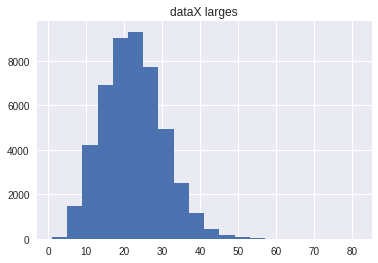

dataX larges mean:  21.85414196876105
dataX larges std:  7.951851909204399
dataX larges max 81


In [80]:

import matplotlib
import matplotlib.pyplot as plt


plt.title('dataX larges')
plt.hist(dataX_larges, bins = 20)

plt.show()

max_input_lenght = dataX_larges.max()

print("dataX larges mean: ", dataX_larges.mean())
print("dataX larges std: ", dataX_larges.std())
print("dataX larges max", max_input_lenght)


In [28]:
frec_labels_sort = []
for lab, num in frec_labels.items():
    frec_labels_sort.append((num, lab))
frec_labels_sort.sort(reverse=True)

frec_lemmas_sort = []
for lemma, num in frec_lemmas.items():
    frec_lemmas_sort.append((num, lemma))
frec_lemmas_sort.sort(reverse=True)

print(frec_labels_sort)

print("\n LEMMAS: \n\n")
for i in range(30):
    print(frec_lemmas_sort[i][1],"\t", frec_lemmas_sort[i][0]/len(dataX))
    
print("\n LABELS: \n\n")
for i in range(15):
    print(frec_labels_sort[i][1],"\t", frec_labels_sort[i][0]/len(dataY))

[(889973, 'O'), (37525, 'B-geo'), (20193, 'B-tim'), (20184, 'B-org'), (17382, 'I-per'), (17011, 'B-per'), (16537, 'I-org'), (16392, 'B-gpe'), (7409, 'I-geo'), (6298, 'I-tim'), (434, 'B-art'), (348, 'B-eve'), (297, 'I-eve'), (280, 'I-art'), (229, 'I-gpe'), (226, 'B-nat'), (76, 'I-nat')]

 LEMMAS: 


the 	 1.3365154634886962
. 	 0.9961315280464217
, 	 0.6756307065160875
in 	 0.5820802395956823
of 	 0.5495102015349098
to 	 0.4878434308770616
a 	 0.47621721678001705
and 	 0.42078991701503715
's 	 0.22697115284623864
say 	 0.20128533100393087
for 	 0.18106944531103764
has 	 0.1493937314115763
on 	 0.1492897402300285
is 	 0.14211434870322998
that 	 0.13456458892285933
it 	 0.1327759406002371
have 	 0.11744764044009068
with 	 0.11378715084960796
said 	 0.11114577483829371
was 	 0.10274328736923109
at 	 0.09798049125434163
from 	 0.09494394875314573
by 	 0.09346727397516691
he 	 0.09132505563528213
an 	 0.0887876708055157
as 	 0.08749818015432291
offici 	 0.08716540837336993
u.s. 	 0.085605540

Podemos apreciar el porcentaje de los 10 lemmas y labels con mas aparición.

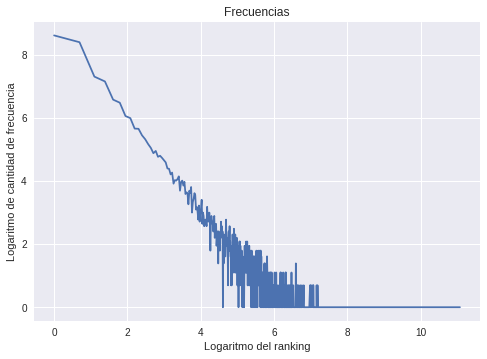

In [31]:
from math import log

frecuencias = dict()

for i in frec_lemmas_sort:
    if i[0] not in frecuencias:
        frecuencias[i[0]] = 0
    frecuencias[i[0]] += 1
    

x = [log(i[0]) for i in frecuencias.items()]
y = [log(i[1]) for i in frecuencias.items()]
    
plt.xlabel('Logaritmo del ranking')
plt.ylabel('Logaritmo de cantidad de frecuencia')    
plt.title('Frecuencias')
plt.plot(x,y)

plt.show()
    



#### Comentario

Podemos apreciar que se cumple la ley de Zipf, debido a que unas muy pocas palabras acumulan un porcentaje grande de las apariciones, mientras que mientras mas crece el número de apariciones por palabra, menos palabras con este numero de apariciones hay.

### c) Pasando lemmas y tags a números

In [32]:
lemma2idx = {w: i for i, w in enumerate(lemmas,1)} #Converting text to numbers
lab2idx = {t: i for i, t in enumerate(labels,1)}
lemma2idx["ENDPAD"] = 0
lab2idx["ENDPAD"] = 0

dataX_numbers = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]
dataY_numbers = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY]
n_lemmas = len(lemmas)+1
n_labels = len(labels)+1

print("n_lemmas (incluyendo ENDPAD): ", n_lemmas)
print("n_labels (incluyendo ENDPAD): ", n_labels)

n_lemmas (incluyendo ENDPAD):  20244
n_labels (incluyendo ENDPAD):  18


#### Padding

In [0]:
def zeros_padding(lista, n):
    return lista[:n] + [0]*(n-len(lista))

dataX_numbers_padd = list(map(lambda x: zeros_padding(x, max_input_lenght), dataX_numbers))
dataY_numbers_padd = list(map(lambda x: zeros_padding(x, max_input_lenght), dataY_numbers))

### d) Aplicando padding 

In [34]:
from keras.preprocessing import sequence
X = sequence.pad_sequences(dataX_numbers, maxlen=max_input_lenght,padding='post', value=lemma2idx["ENDPAD"]) 
y = sequence.pad_sequences(dataY_numbers, maxlen=max_input_lenght,padding='post', value=lab2idx["ENDPAD"])

print(len(X[0]))
print(X[0])

Using TensorFlow backend.


81
[13317  9710  1989  2371  1445 20084  8465  1445   148  9999  1277 11512
 11907 12350 15842  7689 18153  5867  2953 17897  3616 18153 18696 18153
 19327  1445 18365 17765 18153 15609     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0]


### e) Transformando a one hot vector


In [0]:
from keras.utils import to_categorical
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

Las dimensiones de entrada son 42, numeros que van desde 0 a 1253, y la dimensión de salida es 15, un numero booleano por cada tag existente

### f) Entrenando primer modelo

In [36]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
history_f = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
lstm_1 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dense_1 (Dense)              (None, 81, 18)            1818      
Total params: 702,826
Trainable params: 702,826
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 66s 2ms/step - loss: 0.5160 - val_loss: 0.2215
Epoch 2/3
33656/33656 [==============================] - 63s 2ms/step - loss: 0.1655 - val_loss: 0.1219
Epoch 3/3
33656/33656 [==============================] - 63s 2ms/step - loss: 0.1057 - val_loss: 0.0928


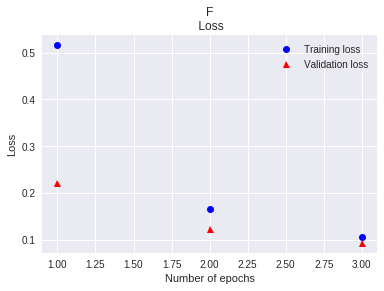

In [39]:
plot_history(history_f.history, "F")

In [0]:
def onehot_to_number(vector):
    vector = list(vector)
    maxpos = vector.index(max(vector))
    return maxpos

def categorical_to_num(lista):
    categorical = list()
    for sequence in lista:
        for vector in sequence:
            number = onehot_to_number(vector)
            categorical.append(number)
    return categorical

def multi_to_one_output(lista):
    ret = list()
    for seq in lista:
        for j in seq:
            ret.append(j)
    return ret
        

#### Removing padding en test set

Para poder comparar resultados y calcular el f1-score debemos eliminar el padding utilizado en el X_test y el Y_test.
Esto para esto eliminamos todos los 0, que corresponden a las etiquetas "ENDPAD" agregados enteriormente.

In [0]:
one_hot_zero = list([1.]+ [0.]*(n_labels-1))

In [0]:
# X_test_no_pad no es necesario, solo el y_test_no_pad

X_test_no_pad = list(map(lambda l: list(filter(lambda a: a != 0., l)), list(X_test))) 
y_test_no_pad = list(map(lambda l: list(filter(lambda a: list(a) != one_hot_zero, l)), list(y_test)))

Chequeando si la conversión esta bien

In [43]:
if len(X_test_no_pad) != len(y_test_no_pad):
    print("Cuidado largos no iguales")
else:
    print("Largos iguales")

Largos iguales


In [44]:
count = 0
for i in range(len(X_test_no_pad)):
    if len(X_test_no_pad[i]) != len(y_test_no_pad[i]):
        count += 1
print("Secuencias de largo distinto: ", count)

Secuencias de largo distinto:  0


#### Prediciendo

Predecimos los tag para la secuencia de X_test que si tiene padding. Esto se hace debido a que el padding es necesario para poder alimentar la red, luego se comparara el resultado con el X_test_no_pad, el X de prueba sin padding, para asi eliminar el padding.

In [0]:
y_predict = model.predict(X_test,verbose=0)
y_predict_2 = model.predict_classes(X_test,verbose=0)

Eliminamos el padding en el y_predict. Para cada secuencia en y_predict, reducimos su largo al largo de su secuencia equivalente en el X de test que no posee padding.

In [0]:
y_predict_no_pad = list()
for i in range(len(X_test_no_pad)):
    y_predict_no_pad.append(y_predict[i][:len(X_test_no_pad[i])])
    
y_predict_2_no_pad = list()
for i in range(len(X_test_no_pad)):
    y_predict_2_no_pad.append(y_predict_2[i][:len(X_test_no_pad[i])])

In [47]:
count = 0
for i in range(len(X_test_no_pad)):
    if len(X_test_no_pad[i]) != len(y_predict_no_pad[i]):
        count += 1
print("Secuencias de largo distinto: ", count)

Secuencias de largo distinto:  0


In [0]:
y_test_cat = categorical_to_num(y_test_no_pad)
y_predict_cat = categorical_to_num(y_predict_no_pad)
y_predict_2_cat = multi_to_one_output(y_predict_2_no_pad)

In [49]:
from sklearn.utils.multiclass import type_of_target

print(type_of_target(y_test_cat))
print(type_of_target(y_predict_cat))
print(type_of_target(y_predict_2_cat))

multiclass
multiclass
multiclass


In [50]:
from sklearn.metrics import f1_score

print("F1 score on test (predict): \t", f1_score(y_test_cat, y_predict_cat, average='weighted'))


print("F1 score on test (predict_classes): \t", f1_score(y_test_cat, y_predict_2_cat, average='weighted'))



F1 score on test (predict): 	 0.8843428355707884
F1 score on test (predict_classes): 	 0.8843428355707884


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Comentario

Podemos observar que el f1 score es bastante bueno. En un principio dio un f1 score de 0.97, lo que era bastante sospechoso, y se debía a que no se había eliminado el padding. Luego de eliminarlo nos da 0.9.

**OBSERVACIÓN:** Para que se tome en cuenta el desbalanceo de clases se uso "'weighted'". Se supone que esto nos permite trabajar con clases desbalanceadas. También se le podría dar a esta función un arreglo de pesos, pero no hay mucha información de como usar esto. Su documentación es: 
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall. 

### g) Cambiando el tamaño del embedding 

Tamaño de embedding a la mitad

In [51]:

embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
history_g = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 81, 16)            323904    
_________________________________________________________________
lstm_2 (LSTM)                (None, 81, 100)           46800     
_________________________________________________________________
dense_2 (Dense)              (None, 81, 18)            1818      
Total params: 372,522
Trainable params: 372,522
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 64s 2ms/step - loss: 0.5560 - val_loss: 0.2459
Epoch 2/3
33656/33656 [==============================] - 64s 2ms/step - loss: 0.2009 - val_loss: 0.1463
Epoch 3/3
33656/33656 [==============================] - 64s 2ms/step - loss: 0.1200 - val_loss: 0.1050


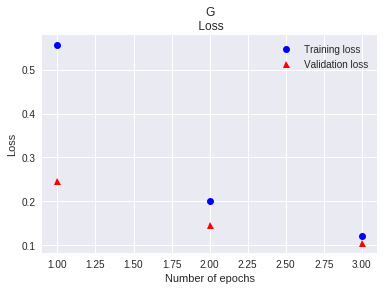

In [52]:
plot_history(history_g.history, "G")

In [0]:
y_predict = model.predict(X_test,verbose=0)

In [0]:
y_predict_no_pad = list()
for i in range(len(X_test_no_pad)):
    y_predict_no_pad.append(y_predict[i][:len(X_test_no_pad[i])])

In [0]:
y_test_cat = categorical_to_num(y_test_no_pad)
y_predict_cat = categorical_to_num(y_predict_no_pad)

In [56]:
print("F1 score on test: ", f1_score(y_test_cat, y_predict_cat, average='weighted'))

F1 score on test:  0.856893615774678


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Comentario

Empeora un poco con respecto al anterior pero bastante poco. Esto debido a que el vector embedding tiene un óptimo para algún valor, que se debe buscar en base a la experimentación, es decir es un hiperparámetro.

### h) Aplicando Dropout

In [57]:
from keras.layers import Dropout

embedding_vector = 32

model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
history_h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 65s 2ms/step - loss: 0.5126 - val_loss: 0.2259
Epoch 2/3
33656/33656 [==============================] - 64s 2ms/step - loss: 0.1771 - val_loss: 0.1263
Epoch 3/3
33656/33656 [==============================] - 64s 2ms/step - loss: 0.1104 - val_loss: 0.0945


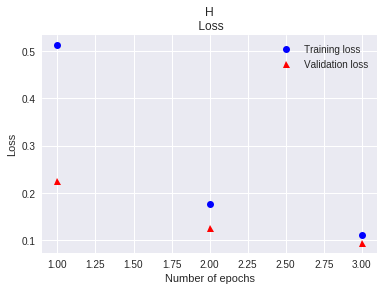

In [58]:
plot_history(history_h.history, "H")

In [59]:
y_predict = model.predict(X_test,verbose=0)

y_predict_no_pad = list()
for i in range(len(X_test_no_pad)):
    y_predict_no_pad.append(y_predict[i][:len(X_test_no_pad[i])])
    
y_test_cat = categorical_to_num(y_test_no_pad)
y_predict_cat = categorical_to_num(y_predict_no_pad)

print("F1 score on test: ", f1_score(y_test_cat, y_predict_cat, average='weighted'))

F1 score on test:  0.8825447645223528


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### i) Red Bidireccional

In [60]:
from keras.layers import Bidirectional

embedding_vector = 32

model = Sequential()

model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode='concat'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
history_i = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 81, 200)           106400    
_________________________________________________________________
dense_4 (Dense)              (None, 81, 18)            3618      
Total params: 757,826
Trainable params: 757,826
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 123s 4ms/step - loss: 0.3890 - val_loss: 0.2065
Epoch 2/3
33656/33656 [==============================] - 121s 4ms/step - loss: 0.1826 - val_loss: 0.1341
Epoch 3/3
33656/33656 [==============================] - 121s 4ms/step - loss: 0.1066 - val_loss: 0.0873


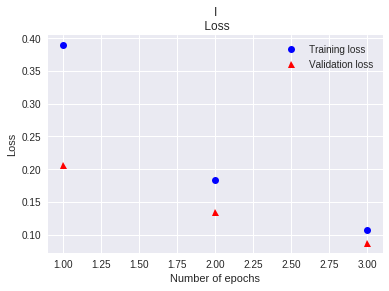

In [61]:
plot_history(history_i.history, "I")

In [63]:
y_predict = model.predict(X_test,verbose=0)

y_predict_no_pad = list()
for i in range(len(X_test_no_pad)):
    y_predict_no_pad.append(y_predict[i][:len(X_test_no_pad[i])])
    
y_test_cat = categorical_to_num(y_test_no_pad)
y_predict_cat = categorical_to_num(y_predict_no_pad)

print("F1 score on test: ", f1_score(y_test_cat, y_predict_cat, average='weighted'))

F1 score on test:  0.8949796597834594


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Comentario

Buen resultado logrado con la capa bidireccional. Esta tiene sentido que sirva más debido a que en una oración las palabras pueden dar sentido a palabras tanto antes como después en la oración.

### j) Mask Zero

In [107]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght,mask_zero=True))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
history_j = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 81, 32)            647808    
_________________________________________________________________
lstm_6 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dense_16 (Dense)             (None, 81, 18)            1818      
Total params: 702,826
Trainable params: 702,826
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 88s 3ms/step - loss: 0.8490 - val_loss: 0.4397
Epoch 2/3
33656/33656 [==============================] - 85s 3ms/step - loss: 0.3903 - val_loss: 0.3554
Epoch 3/3
33656/33656 [==============================] - 85s 3ms/step - loss: 0.3002 - val_loss: 0.2562


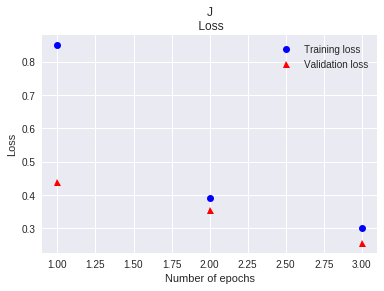

In [108]:
plot_history(history_j.history, "J")

In [66]:
y_predict = model.predict(X_test,verbose=0)

y_predict_no_pad = list()
for i in range(len(X_test_no_pad)):
    y_predict_no_pad.append(y_predict[i][:len(X_test_no_pad[i])])
    
y_test_cat = categorical_to_num(y_test_no_pad)
y_predict_cat = categorical_to_num(y_predict_no_pad)

print("F1 score on test: ", f1_score(y_test_cat, y_predict_cat, average='weighted'))

F1 score on test:  0.9212619460701132


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Comentario

Mejor modelo logrado hasta el momento. Se debe a que no se toman en cuenta los ceros agregador por padding, gracias a esta máscara que se aplica.

### k) GRU y Vainilla



#### GRU

In [67]:
from keras.layers import Dropout
from keras.layers import GRU
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(GRU(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
history_k_1 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)



Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 55s 2ms/step - loss: 0.5038 - val_loss: 0.1621
Epoch 2/3
33656/33656 [==============================] - 53s 2ms/step - loss: 0.1221 - val_loss: 0.0945
Epoch 3/3
33656/33656 [==============================] - 54s 2ms/step - loss: 0.0796 - val_loss: 0.0676


In [68]:
y_predict = model.predict(X_test,verbose=0)

y_predict_no_pad = list()
for i in range(len(X_test_no_pad)):
    y_predict_no_pad.append(y_predict[i][:len(X_test_no_pad[i])])
    
y_test_cat = categorical_to_num(y_test_no_pad)
y_predict_cat = categorical_to_num(y_predict_no_pad)

print("F1 score on test: ", f1_score(y_test_cat, y_predict_cat, average='weighted'))

F1 score on test:  0.925433812048334


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Vainilla/Simple

In [93]:
from keras.layers import Dropout
from keras.layers import SimpleRNN
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(SimpleRNN(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
history_k_2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)


Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 26s 759us/step - loss: 0.4729 - val_loss: 0.2301
Epoch 2/3
33656/33656 [==============================] - 24s 707us/step - loss: 0.1804 - val_loss: 0.1229
Epoch 3/3
33656/33656 [==============================] - 24s 709us/step - loss: 0.1037 - val_loss: 0.0871


In [94]:
y_predict = model.predict(X_test,verbose=0)

y_predict_no_pad = list()
for i in range(len(X_test_no_pad)):
    y_predict_no_pad.append(y_predict[i][:len(X_test_no_pad[i])])
    
y_test_cat = categorical_to_num(y_test_no_pad)
y_predict_cat = categorical_to_num(y_predict_no_pad)

print("F1 score on test: ", f1_score(y_test_cat, y_predict_cat, average='weighted'))

F1 score on test:  0.8941034031416356


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Podemos apreciar que el modelo GRU es superior al Vainilla simple.

### l) Prediciendo un ejemplo

In [0]:
def invertir_dict(d):
    ret = dict()
    for k,v in d.items():
        ret[v] = k
    return ret


In [110]:
lemma_dict = invertir_dict(lemma2idx)
tags_dict = invertir_dict(lab2idx)

i = 200
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y = y_test[i]
y = np.argmax(y, axis=-1)
print("{:15}: {:10}: {}:".format("Lemma", "Pred", "Y"))
for w,pred,y in zip(X_test[i],p[0], y):
    print("{:15}: {:10}: {}".format(lemma_dict[w],tags_dict[pred], tags_dict[y]))
    

Lemma          : Pred      : Y:
1861           : O         : B-tim
,              : O         : O
the            : O         : O
dominican      : B-geo     : B-gpe
voluntarili    : O         : O
return         : O         : O
to             : O         : O
the            : O         : O
spanish        : B-gpe     : B-gpe
empir          : O         : O
,              : O         : O
but            : O         : O
two            : O         : B-tim
year           : O         : O
later          : B-tim     : B-tim
they           : O         : O
launch         : O         : O
a              : O         : O
war            : O         : O
that           : O         : O
restor         : O         : O
independ       : O         : O
in             : O         : O
1865           : B-geo     : B-tim
.              : O         : O
a              : O         : O
ENDPAD         : O         : ENDPAD
ENDPAD         : O         : ENDPAD
ENDPAD         : O         : ENDPAD
ENDPAD         : O         : E

#### Comentario

Apreciamos que el modelo logra predecir muy bien la clase mas significativa, que es "O". Sin embargo no parece funcionar para otras etiquetas. Aunque si parece diferenciar entre cuando la etiqueta debería ser "O" y cuando no.

### m) Cargando palabras del dataset

In [97]:
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() #corpus
null_character = "*"
chars = [null_character]+sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
maxlen = 40 # cut the text in semi-redundant sequences of maxlen characters
step = 5 
sentences = []
next_chars = []
size = int(len(text)*0.2) #solo un 20% del corpus
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))


total chars: 72
nb sequences: 242693


### n) 

In [98]:



dataX = [[char_indices[char] for char in sentence ] for sentence in sentences]
dataY = [char_indices[char] for char in next_chars]
...#dataX pad sequence padding='pre'
...#dataY to categorical with num_classes=len(chars)
from keras.preprocessing import sequence
X = sequence.pad_sequences(dataX, maxlen=maxlen+1,padding='pre', value=char_indices[null_character])
y = np.asarray([to_categorical(i, num_classes=len(chars)) for i in dataY])

from keras.layers import CuDNNGRU,GRU
embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen+1))#
model.add(CuDNNGRU(units=512,return_sequences=False)) #or GRU
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 41, 16)            1152      
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 512)               814080    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 72)                36936     
Total params: 852,168
Trainable params: 852,168
Non-trainable params: 0
_________________________________________________________________


### o) 

In [99]:
def predict_next_char(model, sentence):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen+1,padding='pre',value=char_indices[null_character])
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.random.choice(len(chars), p=preds) #take a sample
    return indices_char[next_index]
import random,sys
def on_epoch_end(epoch, logs):
    """Function invoked at end of each epoch. Prints generated text."""
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(model, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return
from keras.callbacks import LambdaCallback
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X, y,batch_size=256,epochs=25, callbacks=[print_callback])


Epoch 1/25
242693/242693 [==============================] - 46s 191us/step - loss: 2.4832 - acc: 0.2820

----- Generating text after Epoch: 0
----- Generating with seed: "a shotgun at a flying bird without reali"
a shotgun at a flying bird without realissas anterre to kilent the daseded mo the doly ther comtoro turestarion 20 , asardy and ragbilel runtark in " fulmly bo cithos bor on-harou sies ben of ghanst 1ud flo thoue ther intsorled that . the hove civer conuncy way say ano the vecerts . whe pon's alnestmofian jeal , 0han anw oursulg wil the porne unfirg ang conatian tho fhargint the ported fe prep grenmded to pole-ty . det and ofe bersian oEpoch 2/25
242693/242693 [==============================] - 45s 183us/step - loss: 1.9578 - acc: 0.4218

----- Generating text after Epoch: 1
----- Generating with seed: " arrest warrants for kony and other memb"
 arrest warrants for kony and other membou prisen on intecties , and attack be nort syite res over the egentias of a termoting alous ,

#### Comentario

El método utilizado para predecir los siguientes caracteres es mediante la red neuronal que recibe un string y predice el siguiente caracter. De esta manera se puede repetir este proceso varias veces dandole a la red el mismo string mas el string predecido.


### p) 

In [100]:
sentence = "it is "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()

----- Generating with seed: "it is "
it is exerlage to avel peopold haddie endine protell won1 . hejbel halfoving terrat well froud havak hurl , fourd blast and hit ex the 20-ye3s he ally human are gutmin ispanato . the iaran jourd authoritiofia , whe , as leed the plot to disabtion , and over offle is abart has pending to tour a developman . one human arabiz , askic authoratth 'ar jultal of jigrep regai found herbives warling formar haved

Podemos ver que la red no logra formar oraciones con sentido. Lo que si hace es poder generar palabras separadas que parecen texto solo si no se lee detenidamente.

<a id="refs"></a>
## Referencias
[1] George Kingsley Zipf (1949), *Human behavior and the principle of least effort*, Addison-Wesley Press  
[2] https://www.nvidia.es/object/cuda-parallel-computing-es.html  
[3] http://yann.lecun.com/exdb/mnist/  
[4] Vincent, P., Larochelle, H., Bengio, Y., & Manzagol, P. A. (2008, July). *Extracting and composing robust features with denoising autoencoders*. ACM.